In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import defaultdict
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from pathlib import Path, PurePath
from imutils import paths

In [2]:
class config:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LABELS = ['frog_eye_leaf_spot', 'healthy', 'rust', 'scab', 'complex', 'powdery_mildew']
    NUM_CLASSES = len(LABELS)

In [191]:
image_paths = list(paths.list_images('train_images'))
progress_bar = tqdm(total=len(image_paths), desc='Resizing images')
output_size = (224, 224)

for image_path in image_paths:
    image_path = Path(image_path)
    image = Image.open(image_path)

    resized_image = image.resize(output_size)
    output_path = Path('train_images') / image_path.name

    resized_image.save(output_path)
    progress_bar.update(1)

progress_bar.close()

Resizing images:   0%|          | 0/18632 [00:00<?, ?it/s]

In [3]:
def split_df(csv_dir):
    df = pd.read_csv(csv_dir)
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=23)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.66, shuffle=True, random_state=23)

    return train_df, valid_df, test_df
    # return train_df, dummy_df

In [4]:
# train_df, valid_df, test_df = split_df('train.csv')
train_df, valid_df, test_df = split_df('train.csv')

In [5]:
def create_new_df(df):
    dct = defaultdict(list)

    for i, label in enumerate(df.labels):
        for category in label.split():
            dct[category].append(i)

    dct = {key: np.array(val) for key, val in dct.items()}

    new_df = pd.DataFrame(np.zeros((df.shape[0], len(dct.keys())), dtype=np.int8), columns=dct.keys())

    for key, val in dct.items():
        new_df.loc[val, key] = 1
    
    new_df = new_df[config.LABELS]

    return new_df

In [6]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.annotations = df
        self.transform = transform

        self.new_df = create_new_df(df)

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')
        label = torch.tensor(self.new_df.iloc[index, :], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
])
test_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
])

In [8]:
train_dataset = PlantDiseaseDataset(train_df, 'train_images', train_transform)
val_dataset = PlantDiseaseDataset(valid_df, 'train_images', test_transform)
test_dataset = PlantDiseaseDataset(test_df, 'train_images', test_transform)

In [9]:
image, label = next(iter(train_dataset))
label

tensor([1., 0., 0., 0., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


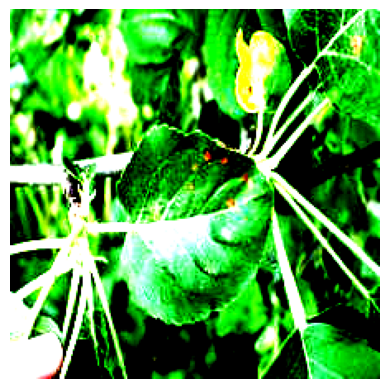

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [9]:
train_dataset.new_df.keys()

Index(['frog_eye_leaf_spot', 'healthy', 'rust', 'scab', 'complex',
       'powdery_mildew'],
      dtype='object')

In [10]:
val_dataset.new_df.keys()

Index(['frog_eye_leaf_spot', 'healthy', 'rust', 'scab', 'complex',
       'powdery_mildew'],
      dtype='object')

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(nn.Dropout(0.2, inplace=True),
                                 nn.Linear(1280, 6, bias=True))
# for param in model.features.parameters():
#     param.requires_grad = False
# model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=6, bias=True))

model = model.to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.load_state_dict(torch.load(f='models/model.pth'))

<All keys matched successfully>

In [16]:
all_labels = train_df['labels'].str.split(expand=True).stack().reset_index(drop=True)
all_labels

0        frog_eye_leaf_spot
1                   healthy
2        frog_eye_leaf_spot
3                      rust
4        frog_eye_leaf_spot
                ...        
14116        powdery_mildew
14117                  scab
14118                  rust
14119    frog_eye_leaf_spot
14120               complex
Length: 14121, dtype: object

In [17]:
class_counts = all_labels.value_counts()[config.LABELS]
class_counts

frog_eye_leaf_spot    3051
healthy               3249
rust                  1458
scab                  3974
complex               1520
powdery_mildew         869
Name: count, dtype: int64

In [18]:
# Compute inverse class frequency
class_weights = torch.reciprocal(torch.tensor(class_counts.values).float()) # invert the counts and convert them to floats
class_weights /= torch.max(class_weights) # normalize the weights by the maximum weight

In [19]:
optimizer = optim.Adam(model.parameters(), 0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to('cuda'))
class_weights

tensor([0.2848, 0.2675, 0.5960, 0.2187, 0.5717, 1.0000])

In [20]:
num_epochs = 10

In [21]:
torch.cuda.is_available()
torch.backends.cudnn.benchmark = True

In [22]:
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    val_loss = 0
    total_preds = 0
    correct_preds = 0

    for batch_idx, (image, label) in enumerate(tqdm(train_loader)):
        image = image.to(device)
        label = label.to(device)

        with torch.cuda.amp.autocast():
            out = model(image)
            loss = loss_fn(out, label)

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(out) > 0.50).int()
        total_preds += label.shape[0]
        correct_preds += torch.sum((preds == label).all(dim=1))

    train_loss /= len(train_loader)
    all_train_loss.append(train_loss)
    train_acc = correct_preds / total_preds
    all_train_acc.append(train_acc)

    print(f"Epoch: {epoch} with train_loss: {train_loss} and train_acc: {train_acc * 100}%")

    model.eval()
    total_preds = 0
    correct_preds = 0

    for batch_idx, (image, label) in enumerate(tqdm(val_loader)):
        image = image.to(device)
        label = label.to(device)

        with torch.no_grad():
            out = model(image)

        loss = loss_fn(out, label)
        val_loss += loss.item()

        preds = (torch.sigmoid(out) > 0.50).int()
        total_preds += label.shape[0]
        correct_preds += torch.sum((preds == label).all(dim=1))

    val_loss /= len(val_loader)
    all_val_loss.append(val_loss)
    val_acc = correct_preds / total_preds
    all_val_acc.append(val_acc)

    print(f"Epoch: {epoch} with val_loss: {val_loss} and val_acc: {val_acc * 100}%")

    model.train()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 0 with train_loss: 0.014695362993983972 and train_acc: 94.18034362792969%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 0 with val_loss: 0.08680383707717831 and val_acc: 85.03659057617188%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 1 with train_loss: 0.015436287079686663 and train_acc: 93.86597442626953%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 1 with val_loss: 0.09162529177385671 and val_acc: 84.52155303955078%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 2 with train_loss: 0.015310743967739992 and train_acc: 94.3106918334961%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 2 with val_loss: 0.09008322418908235 and val_acc: 85.11791229248047%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 3 with train_loss: 0.014271440245091286 and train_acc: 94.42570495605469%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 3 with val_loss: 0.09474387324961095 and val_acc: 85.19923400878906%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 4 with train_loss: 0.013634713595178361 and train_acc: 94.90875244140625%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 4 with val_loss: 0.09125182775636043 and val_acc: 85.17212677001953%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 5 with train_loss: 0.013567192261974675 and train_acc: 94.88575744628906%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 5 with val_loss: 0.09208540761730923 and val_acc: 84.95526885986328%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 6 with train_loss: 0.013159414222315593 and train_acc: 95.10811614990234%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 6 with val_loss: 0.0962501362463909 and val_acc: 84.95526885986328%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 7 with train_loss: 0.011766708677397202 and train_acc: 95.60650634765625%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 7 with val_loss: 0.0977704569472578 and val_acc: 84.14204406738281%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 8 with train_loss: 0.01210079493181433 and train_acc: 95.63716888427734%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 8 with val_loss: 0.10197803948941672 and val_acc: 84.3046875%


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch: 9 with train_loss: 0.012260580428689946 and train_acc: 95.23079681396484%


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch: 9 with val_loss: 0.10612253584208545 and val_acc: 84.46733093261719%


In [124]:
new_train_acc = []
for i in all_train_acc:
    new_train_acc.append(i.item())

new_val_acc = []
for i in all_val_acc:
    new_val_acc.append(i.item())

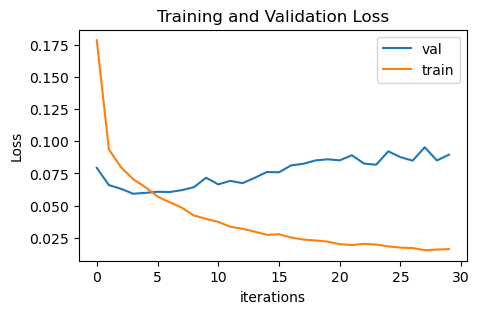

In [147]:
new_all_train_loss = all_train_loss
new_all_val_loss = all_val_loss
plt.figure(figsize=(5,3))
plt.title("Training and Validation Loss")
plt.plot(all_val_loss,label="val")
plt.plot(all_train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

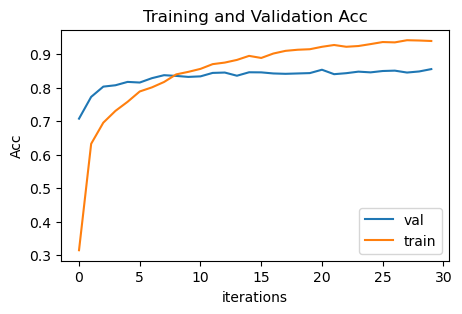

In [136]:
plt.figure(figsize=(5,3))
plt.title("Training and Validation Acc")
plt.plot(new_val_acc,label="val")
plt.plot(new_train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [14]:
model.eval()
total_preds = 0
correct_preds = 0

for batch_idx, (image, label) in enumerate(tqdm(test_loader)):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        out = model(image)

    preds = torch.round(torch.sigmoid(out))
    total_preds += label.shape[0]
    correct_preds += torch.sum((preds == label).all(dim=1))

acc = correct_preds / total_preds

  0%|          | 0/60 [00:00<?, ?it/s]

In [15]:
print(acc * 100)

tensor(84.2188, device='cuda:0')


In [22]:
model.eval()
image, label = next(iter(test_loader))
image = image.to(device)
out = model(image)
preds = torch.round(torch.sigmoid(out))

pred_idx = []
gt_idx = []
pred_labels = [[] for i in range(32)]
gt_labels = [[] for i in range(32)]

for i in range(32):
    # print(f"{i + 1}th image:")
    # pred_labels.append(config.LABELS[preds[i] == 1])
    pred_idx = preds[i] == 1
    for idx, j in enumerate(pred_idx):
        if j == True:
            pred_labels[i].append(config.LABELS[idx])

    gt_idx = label[i] == 1
    for idx, j in enumerate(gt_idx):
        if j == True:
            gt_labels[i].append(config.LABELS[idx])

In [43]:
def decode_label(encoded_label, class_list):
    decoded = [class_list[i] for i, val in enumerate(encoded_label) if val == 1]
    return decoded

In [ ]:
def pred_and_plot_image(image_path, suplot, ground_truth, model, device='cuda'):
    image = Image.open(image_path)
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    image = transform(image)

    model.to(device)
    model.eval()

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        out = model(image)
    preds = (torch.sigmoid(out) > 0.5).int()
    preds = torch.round(preds).squeeze().tolist()
    preds = [int(i) for i in preds]
    pred_labels = decode_label(preds, config.LABELS)

    plt.subplot(*suplot)
    plt.imshow(image)

    title = f"Ground Truth: {ground_truth} | Pred: {' '.join(pred_labels)}"

    plt.axis('off')

In [ ]:
def plot_test_images(model, test_images):
    num_images_to_plot = 30
    test_image_paths = test_images['image'].tolist()
    test_image_labels = test_images['labels'].tolist()
    

In [150]:
from pathlib import Path

In [151]:
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

model_name = 'model.pth'
model_save_path = model_path/model_name

torch.save(obj=model.state_dict(),f=model_save_path)